# Training a Conditional GAN using BCE-loss on the MNIST-Dataset
Conditional gans differ from normal dc-gans in that the class of the generated images can also be controlled. This feature is called controllable generation and is achieved by training both the discriminator and generator with labeled data as opposed to the unlabeled data used to train normal dc-gans. The main distinction here, is that the discriminator in addition to predicting wheather or not the generated image is a real looking image in general, also checks if it is a real looking image of that particular class. How the labels are used in the training of the discriminator and generator is discussed later in the notebook.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

## loading and preprocessing the mnist dataset
Make note to include the labels as well here.

In [ ]:
(xtr,ytr),(_,_)=mnist.load_data()
xtr=np.expand_dims(xtr,-1)
xtr=xtr/255.                 # bring the pixel values to the range 0 to 1
xtr=(xtr-0.5)/0.5            # bring pixel values to range -1 to 1
print("shape of training images: "+str(xtr.shape),"shape of labels: "+str(ytr.shape))

11493376/11490434 [==============================] - 0s 0us/step
shape of training images: (60000, 28, 28, 1) shape of labels: (60000,)


In [ ]:
traindata=tf.data.Dataset.from_tensor_slices((xtr,ytr)).batch(64)
len(traindata)

938

# How the labels play a role :
### Generator :
The generaotor takes in an input noise vector and generates an image. Here, the input noise vector, and the desired class' one-hot encoding vector are concatenated, and this is then fed into the generator in order to generate images of that particular class.
### Discriminator
In the discriminator on the other hand, the labels can be inserted into the training process in multiple ways. Here, we add the label info into the channel-dimension of the images fed into the discriminator. eg: the black and white mnist images have 1 channel. The one-hot label vector is tiled into 28x28 shape using 'tf.tile' and concatenated with the images along the 3rd dimension (channels). After tiling, if the label is of class 2, then the 2nd channel alone will consist of all ones, while all the other 9 channels consist of all zeros. This might be hard to grasp at first, but the implementation is really simple and will help understand the concept better. Thus, a 28x28x1 image is transformed into a 28x28x11 image in this case where the number of classes is 10. 

## create generator architecture

In [ ]:
def get_generator():
  return tf.keras.Sequential([
      tf.keras.layers.Dense(7*7*128,input_shape=(20,)),  #noise vector of length 10 and the one-hot encoding of the class of length 10
      tf.keras.layers.Reshape((7,7,128)),
      
      tf.keras.layers.Conv2DTranspose(64,3,2,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),

      tf.keras.layers.Conv2DTranspose(32,3,2,'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),

      tf.keras.layers.Conv2DTranspose(1,4,1,padding='same',activation='tanh')]
  )

In [ ]:
gen=get_generator()
gen.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              131712    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)       

## create discriminator architecture

In [ ]:
def get_discriminator():
  return tf.keras.Sequential([
                              tf.keras.layers.Conv2D(16,3,2,padding='same',input_shape=(28,28,11)), # label info concatenated with the image
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),

                              tf.keras.layers.Conv2D(32,3,2,padding='same'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),

                              tf.keras.layers.Conv2D(64,3,2,padding='same'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),

                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(1)
  ])

In [ ]:
dis=get_discriminator()
dis.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 16)        1600      
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

## function for concatination of tensors about an axis

In [ ]:
def combine_vectors(x,y,a):
  x=tf.cast(x,tf.float32)
  y=tf.cast(y,tf.float32)
  return tf.concat([x,y],a)

## get one hot encoding

In [ ]:
def getoh(x):
  return tf.one_hot(x,10)

## setup optimizer and loss

In [ ]:
genopt=tf.keras.optimizers.Adam(0.0002,0.5,0.999)
disopt=tf.keras.optimizers.Adam(0.0002,0.5,0.999)
bce=tf.keras.losses.BinaryCrossentropy(from_logits=True)

## print grid of 25 images

In [ ]:
def showout(x):
  x=(x+1)/2.
  x=np.array(x,dtype=np.float32)
  fig=plt.figure(figsize=(5,5))
  p=0
  for i in range(x.shape[0]):
    fig.add_subplot(5,5,p+1)
    plt.imshow(x[i][:,:,0],cmap='gray')
    p+=1
  plt.show()

(25, 28, 28, 1)


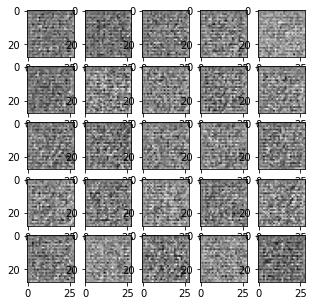

In [ ]:
genimages=gen(tf.random.normal((25,20)))
print(genimages.shape)
showout(genimages)

## training loop

0 epoch number -------------------------------------------------------------


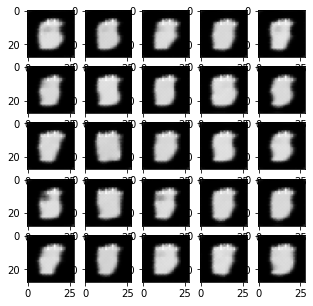

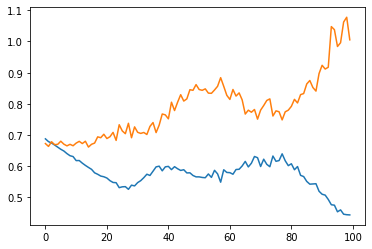

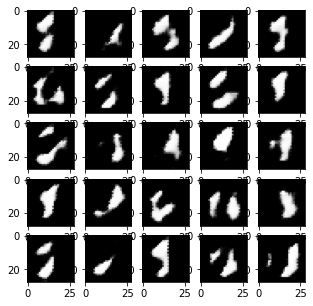

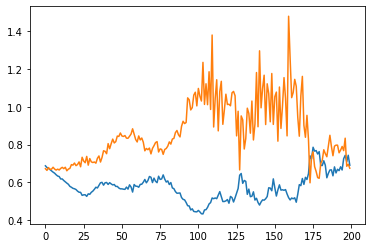

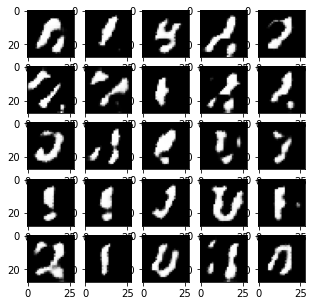

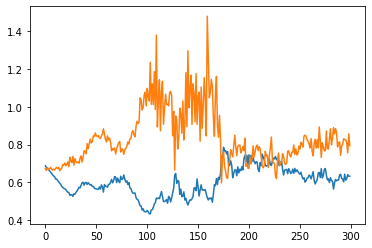

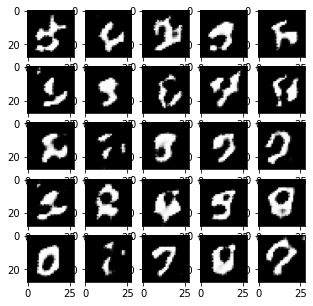

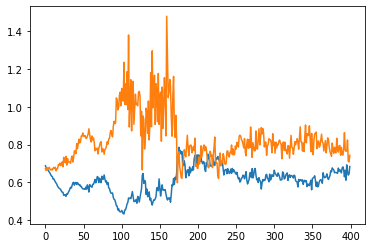

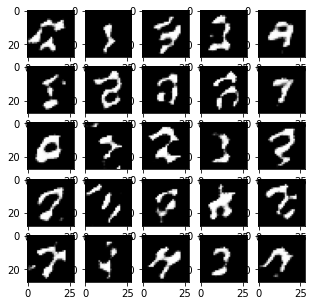

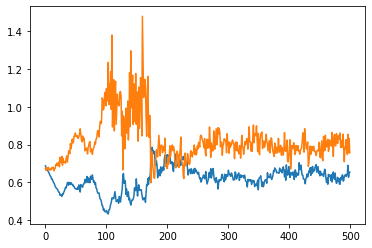

In [ ]:
genlosses=[]
dislosses=[]
iteration=0
for e in range(200):
  print(str(e)+" epoch number -------------------------------------------------------------")
  for realdata in tqdm(traindata):
    realx=realdata[0]         # real images
    labels=realdata[1]        # labels of real images 
    labels_oh=getoh(labels)   # get one hot encoding of labels for input to generator
    curbatchsize=len(realx)
    label_channels=tf.tile( np.reshape(labels_oh,(curbatchsize,1,1,10)) , [1,28,28,1]) 
    # create tiled one-hot channels for discriminator input
    # one-hot labels are first reshaped from (batch-size, 10) into (batch-size, 1, 1, 10)
    # then this is tiled along the 2nd and 3rd dimensions to the size 28x28

    with tf.GradientTape() as distape:                # updating discriminator
      noise1=tf.random.normal((curbatchsize,10))
      inputvec1=combine_vectors(noise1,labels_oh,1)

      fakeimages1=gen(inputvec1)
      realimages1=realx

      f1=combine_vectors(fakeimages1,label_channels,-1)  # concatenate label_channels to fake images and real images
      r1=combine_vectors(realimages1,label_channels,-1)

      fouts=dis(f1)
      routs=dis(r1)

      floss=bce(tf.zeros_like(fouts),fouts)
      rloss=bce(tf.ones_like(routs),routs)

      disloss=(floss+rloss)/2

      disgrads=distape.gradient(disloss,dis.trainable_variables)

      disopt.apply_gradients(zip(disgrads,dis.trainable_variables))

    with tf.GradientTape() as gentape:               # updating generator 
      noise2=tf.random.normal((curbatchsize,10))
      inputvec2=combine_vectors(noise2,labels_oh,1)
      fakeimages2=gen(inputvec2)
      f2=combine_vectors(fakeimages2,label_channels,-1)
      fouts2=dis(f2)
      genloss=bce(tf.ones_like(fouts2),fouts2)
      gengrads=gentape.gradient(genloss,gen.trainable_variables)
      genopt.apply_gradients(zip(gengrads,gen.trainable_variables))

    genlosses.append(genloss)
    dislosses.append(disloss)
    iteration+=1
    if iteration%100==0:   # every 100 iterations, generate using a custom label-vector = CONTROLABLE GENERATION
      consta=tf.constant([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4])
      noise3=tf.random.normal((25,10))
      oh=getoh(consta)
      inputvec3=combine_vectors(noise3,oh,1)
      fakeimages3=gen(inputvec3)
      showout(fakeimages3)
      plt.plot(dislosses)
      plt.plot(genlosses)
      plt.show()

# Generating a GIF 
of transitioning between the different classes by manipulation of the latent vector. generate images from intermediate latent representations and convert the images into a gif.

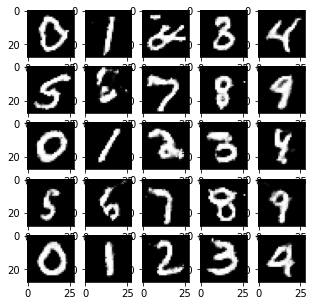

In [ ]:
consta=tf.constant([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4])
noise3=tf.random.normal((25,10))
oh=getoh(consta)
inputvec3=combine_vectors(noise3,oh,1)
fakeimages3=gen(inputvec3)
showout(fakeimages3)

In [ ]:
aa=inputvec3.numpy()
aa.shape

(25, 20)

In [ ]:
bb=[]
for i in range(1,len(aa)):
  start=aa[i-1]
  end=aa[i]
  inc=(end-start)/8
  for i in range(8):
    bb.append(start+i*inc)
bb=np.array(bb)
print(bb.shape)

(192, 20)


In [ ]:
generated_images=gen(bb)
generated_images.shape

TensorShape([192, 28, 28, 1])

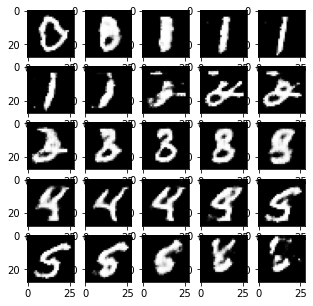

In [ ]:
showout(generated_images[:25])

In [ ]:
import imageio
imageio.mimsave('/content/movie.gif', generated_images.numpy())